In [1]:
# load generals
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def rolling_window_sequences(X, index, window_size, target_size, step_size,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.

    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences.
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.

    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(X[end:end + target_size])  # 모든 열을 타겟 시퀀스로 설정
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/라온 팀폴더/데이터셋/OBDdata/sorted_combined_file_no_duplicates.csv')

# 타겟 컬럼의 이름을 인덱스로 변환
target_columns = ['FuelStatus','PedalPos','ThrottlePos','Load','Speed','RPM']
X = df[target_columns].values

# 2. 결측값 처리
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X_imputed = imp.fit_transform(X)

# 3. MinMaxScaler를 2차원 데이터에 적용
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_imputed)

# 4. X_scaled를 3차원으로 변환 (rolling_window_sequences 함수에 입력하기 위해)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# 5. rolling_window_sequences 함수 정의 (앞에서 정의한 함수 사용)

# 6. 인덱스 생성
index = np.arange(len(df))

# 7. 시퀀스 생성
X, y, X_index, y_index = rolling_window_sequences(
    X=X_reshaped,
    index=index,
    window_size=100,
    target_size=1,
    step_size=1
)

# 8. 결과 확인
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (10506, 100, 6, 1)
Training data index shape: (10506,)
Training y shape: (10506, 1, 6, 1)
Training y index shape: (10506,)


In [5]:
# Check gpu envrionmental
import tensorflow as tf
import logging
import math

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print (gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
LOGGER = logging.getLogger(__name__)

In [7]:
!pip install similaritymeasures


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-1.1.0-py3-none-any.whl size=15428 sha256=e920d4b2e9cb47f0f3e58c97479c4795d4189d0dc4ad53e1dce266fb2ab1e177
  Stored in directory: /root/.cache/pip/wheels/f4/48/ec/2126cdd1eb114d2c826f4ee014c6e80efe5f0095014d338bfc
Successfully built similaritymeasures


In [8]:
!pip install tensorflow


In [9]:
import numpy as np
import pandas as pd
import pickle

#import tensorflow as tf
import keras
import matplotlib.pyplot as plt

import similaritymeasures as sm
from tensorflow.keras import backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense, Reshape, UpSampling1D, TimeDistributed
from tensorflow.keras.layers import Activation, Conv1D, LeakyReLU, Dropout, Add, Layer
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM as CUDNNLSTM
from tensorflow.keras.optimizers import Adam

from functools import partial
from scipy import integrate, stats

In [10]:
# import tensorflow as tf

# # TensorFlow 1.x의 Keras API를 사용하려면 다음과 같이 설정합니다.
# tf.compat.v1.disable_eager_execution()  # TensorFlow 1.x 스타일의 그래프 실행 모드 사용

# # CuDNNLSTM을 가져와 사용
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM as CUDNNLSTM

In [11]:
class RandomWeightedAverage(Layer):
    def _merge_function(self, inputs):
        alpha = K.random_uniform((64, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [12]:
def build_encoder_layer(input_shape, encoder_reshape_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Bidirectional(tf.keras.layers.LSTM(units=100, return_sequences=True))(input_layer)
    x = layers.Flatten()(x)
    x = layers.Dense(20)(x)
    x = layers.Reshape(target_shape=encoder_reshape_shape)(x)
    model = keras.models.Model(input_layer, x, name='encoder')

    return model

def build_generator_layer(input_shape, generator_reshape_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Flatten()(input_layer)
    x = layers.Dense(generator_reshape_shape[0])(x)
    x = layers.Reshape(target_shape=generator_reshape_shape)(x)
    x = layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True), merge_mode='concat')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True), merge_mode='concat')(x)
    x = layers.TimeDistributed(layers.Dense(1))(x)
    x = layers.Activation(activation='tanh')(x)
    model = keras.models.Model(input_layer, x, name='generator')

    return model


def build_critic_x_layer(input_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=5)(input_layer)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Conv1D(filters=64, kernel_size=5)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=1)(x)
    model = keras.models.Model(input_layer, x, name='critic_x')

    return model


def build_critic_z_layer(input_shape):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Flatten()(input_layer)
    x = layers.Dense(units=100)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(units=100)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Dense(units=1)(x)
    model = keras.models.Model(input_layer, x, name='critic_z')

    return model

In [13]:
def wasserstein_loss(y_true, y_pred):
#    return tf.reduce_mean(y_true * y_pred)
    return K.mean(y_true * y_pred)

In [14]:
window_size = 100

In [32]:
# Layer Parameters
encoder_input_shape = (window_size, 1)
generator_input_shape = (20, 1)

critic_x_input_shape = (window_size, 1)
critic_z_input_shape = (20,1)

encoder_reshape_shape = (20, 1)
generator_reshape_shape = (window_size//2, 1) # window_size//3 <- 3 is Upsampling size

learning_rate = 0.00001

# Build Model
encoder = build_encoder_layer(input_shape=encoder_input_shape,
                              encoder_reshape_shape=encoder_reshape_shape)

generator = build_generator_layer(input_shape=generator_input_shape,
                                  generator_reshape_shape=generator_reshape_shape)

critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(0.000007)
critic_z_optimizer = tf.keras.optimizers.Adam(0.000007)

In [33]:
encoder.summary() # Trace를 입력으로 받아 Latent Vector 생성

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 200)            │          81,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │         400,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 20, 1)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,620 (1.84 MB)

 Trainable params: 481,620 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
generator.summary() # Latent Vector 로 부터 유사한 Trace를 생성

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 50)                  │           1,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 50, 128)             │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 100, 1)              │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 100, 1)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,787 (522.61 KB)

 Trainable params: 133,787 (522.61 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
critic_x.summary() # Original input X 에 대한 감시

Model: "critic_x"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 96, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 96, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 96, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 92, 64)              │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 92, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 88, 64)              │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 88, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 88, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 84, 64)              │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 84, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 84, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │           5,377 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,393 (263.25 KB)

 Trainable params: 67,393 (263.25 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
critic_z.summary()  # Generated 되는 것에 대한 감시

Model: "critic_z"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 20, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 100)                 │           2,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,301 (48.05 KB)

 Trainable params: 12,301 (48.05 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:

latent_dim = 20
shape = (window_size, 1)

In [38]:
@tf.function
def critic_x_train_on_batch(x, z):
    # Loss 크게 이상 없음
    with tf.GradientTape() as tape:

        valid_x = critic_x(x)
        x_ = generator(z)
        fake_x = critic_x(x_)

        # Interpolated
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * x + (1 - alpha) * x_

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)

        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
#         grads = tf.square(grads)
#         ddx = tf.sqrt(tf.reduce_sum(grads, axis=np.arange(1, len(grads.shape))))
#        gp_loss = tf.reduce_mean((1.0 - ddx) ** 2)

        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)
        #loss = tf.add_n([loss1, loss2, gp_loss*10.0])
        loss = loss1 + loss2 + gp_loss
#        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    return loss

In [39]:
@tf.function
def critic_z_train_on_batch(x, z):

    with tf.GradientTape() as tape:

        z_ = encoder(x)
        valid_z = critic_z(z)
        fake_z = critic_z(z_) # <- critic_z 의 결과가 매우 않음

        # Interpolated
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * z + (1 - alpha) * z_

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)

        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))

#         grads = tf.square(grads)
#         ddx = tf.sqrt(tf.reduce_sum(grads, axis=np.arange(1, len(grads.shape))))
#         gp_loss = tf.reduce_mean((1.0 - ddx) ** 2)

        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z) # <- 이게 미친듯이 뜀.
        loss = loss1 + loss2 + gp_loss
#        loss = tf.reduce_mean(loss)

    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    return loss

In [40]:
@tf.function
def enc_gen_train_on_batch(x, z):
    with tf.GradientTape() as enc_tape:

        z_gen_ = encoder(x, training=True)
        x_gen_ = generator(z, training=False)
        x_gen_rec = generator(z_gen_, training=False)

        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)

        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        enc_loss = loss1 + loss2 + loss3

    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    with tf.GradientTape() as gen_tape:

        z_gen_ = encoder(x, training=False)
        x_gen_ = generator(z, training=True)
        x_gen_rec = generator(z_gen_, training=True)

        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)

        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3

    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))
    return enc_loss, gen_loss

In [41]:
# Train parameters
batch_size = 64
n_critics = 3
epochs = 10

In [42]:
X.shape

(63036, 100, 1)

In [43]:
tf.config.experimental_run_functions_eagerly(True)

In [44]:
# Data Reshape
X = X.reshape((-1, shape[0], 1))
X_ = np.copy(X)

In [45]:
# fake = np.ones((batch_size, 1), dtype=np.float32)
# valid = -np.ones((batch_size, 1), dtype=np.float32)
# delta = np.ones((batch_size, 1), dtype=np.float32)

epoch_e_loss = []
epoch_g_loss = []
epoch_cx_loss = []
epoch_cz_loss = []

for epoch in range(1, epochs+1):

    np.random.shuffle(X_)

    minibatches_size = batch_size * n_critics  # 64*5 = 320
    num_minibatches = int(X_.shape[0] // minibatches_size)  # 12

    encoder.trainable = False
    generator.trainable = False

    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]

        # Number of Critics
        for j in range(n_critics):

            x = minibatch[j * batch_size: (j + 1) * batch_size]
            z = tf.random.normal(shape=(batch_size, latent_dim, 1), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)

            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x, z))
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x, z))

        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True

        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)

    # cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    # cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    # e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    # g_loss = np.mean(np.array(epoch_g_loss), axis=0)



    cx_loss = np.mean([tensor.numpy() for tensor in epoch_cx_loss], axis=0)
    cz_loss = np.mean([tensor.numpy() for tensor in epoch_cz_loss], axis=0)
    e_loss = np.mean([tensor.numpy() for tensor in epoch_e_loss], axis=0)
    g_loss = np.mean([tensor.numpy() for tensor in epoch_g_loss], axis=0)


    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))

Epoch: 1/10, [Dx loss: 1.2170393466949463] [Dz loss: 3.380693197250366] [E loss: 0.355015367269516] [G loss: 0.3159427046775818]
Epoch: 2/10, [Dx loss: -1.0487682819366455] [Dz loss: 2.4743597507476807] [E loss: 0.22901208698749542] [G loss: 0.15032191574573517]
Epoch: 3/10, [Dx loss: -2.1607072353363037] [Dz loss: 1.8618429899215698] [E loss: 0.8478885889053345] [G loss: 0.7818745374679565]
Epoch: 4/10, [Dx loss: -2.7386245727539062] [Dz loss: 3.197713613510132] [E loss: -0.25995901226997375] [G loss: -0.3444594144821167]
Epoch: 5/10, [Dx loss: -3.115445137023926] [Dz loss: 2.420463800430298] [E loss: 1.0379055738449097] [G loss: 0.9377276301383972]
Epoch: 6/10, [Dx loss: -3.370795726776123] [Dz loss: 2.2053887844085693] [E loss: 1.5580015182495117] [G loss: 1.4617737531661987]
Epoch: 7/10, [Dx loss: -3.550774335861206] [Dz loss: 2.234764575958252] [E loss: 1.8272607326507568] [G loss: 1.7424598932266235]
Epoch: 8/10, [Dx loss: -3.6943905353546143] [Dz loss: 2.2116315364837646] [E los

In [46]:
# Keras Native Format으로 모델 저장
encoder.save('encoder_model.keras')
generator.save('generator_model.keras')
critic_x.save('critic_x_model.keras')
critic_z.save('critic_z_model.keras')


In [47]:
from tensorflow.keras.models import load_model

# 모델 로드
encoder = load_model('encoder_model.keras')
generator = load_model('generator_model.keras')
critic_x = load_model('critic_x_model.keras')
critic_z = load_model('critic_z_model.keras')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


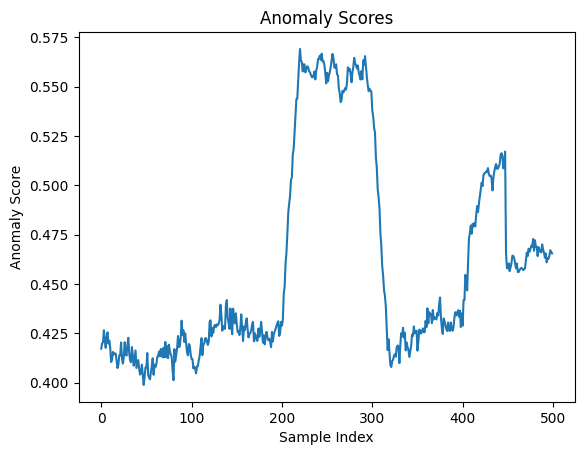

Detected anomalies at indices: [219 220 221 222 224 225 240 241 242 243 244 245 246 247 255 256 257 260
 280 281 282 284 290 291 292]


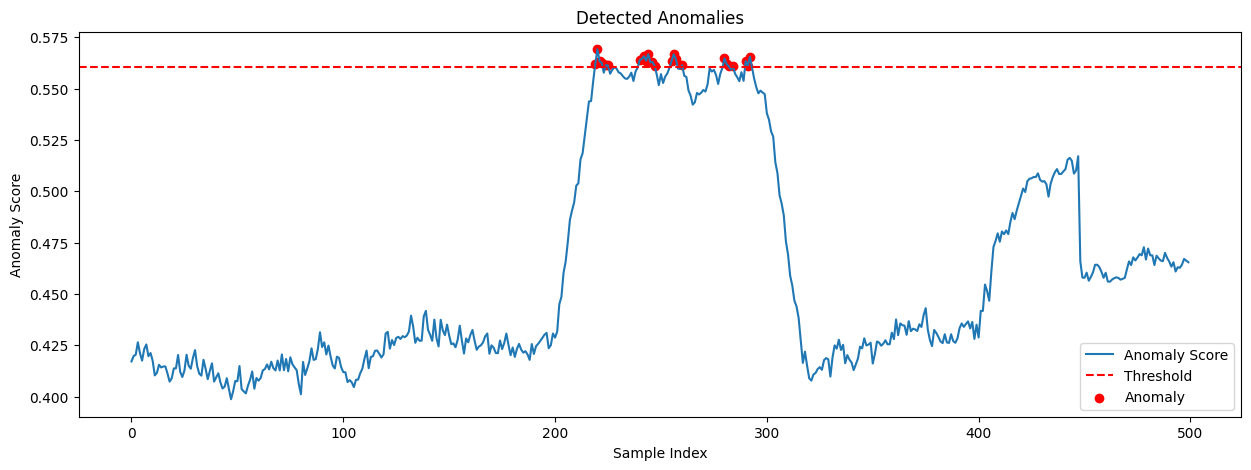

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# 1. 데이터 로드
data_path = '/content/simulated_double_sudden_acceleration.csv'
df = pd.read_csv(data_path)

# 타겟 컬럼의 이름을 인덱스로 변환
target_columns = ['FuelStatus', 'PedalPos', 'ThrottlePos', 'Load', 'Speed', 'RPM']
X = df[target_columns].values

# 2. 결측값 처리
imp = SimpleImputer(strategy='mean')
X_imputed = imp.fit_transform(X)

# 3. MinMaxScaler를 2차원 데이터에 적용
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X_imputed)

# 4. X_scaled를 3차원으로 변환 (rolling_window_sequences 함수에 입력하기 위해)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# 5. rolling_window_sequences 함수 정의
def rolling_window_sequences(X, index, window_size, target_size, step_size):
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size
        out_X.append(X[start:end])
        out_y.append(X[end:end + target_size])  # 모든 열을 타겟 시퀀스로 설정
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

# 6. 인덱스 생성
index = np.arange(len(df))

# 7. 시퀀스 생성
X_test, y_test, X_test_index, y_test_index = rolling_window_sequences(
    X=X_reshaped,
    index=index,
    window_size=100,
    target_size=1,
    step_size=1
)

# 8. 저장된 모델 로드
encoder = load_model('/content/encoder_model.keras')
generator = load_model('/content/generator_model.keras')
critic_x = load_model('/content/critic_x_model.keras')
critic_z = load_model('/content/critic_z_model.keras')

# 9. 이상 점수 계산 함수 정의
def calculate_anomaly_score(x, encoder, generator):
    z = encoder.predict(x)
    x_reconstructed = generator.predict(z)

    # x_reconstructed의 차원을 x와 맞추기 위해 차원 확장
    x_reconstructed = np.expand_dims(x_reconstructed, axis=-1)  # 마지막 차원에 1 추가

    # 3차원을 1차원으로 축소
    loss = np.mean(np.abs(x - x_reconstructed), axis=(1, 2, 3))  # 모든 차원에 대해 평균 계산
    return loss

# 10. 이상 점수 계산
anomaly_scores = []
batch_size = 64  # 배치 사이즈 설정

for i in range(0, len(X_test), batch_size):
    x_batch = X_test[i:i + batch_size]
    scores = calculate_anomaly_score(x_batch, encoder, generator)
    anomaly_scores.extend(scores)

# 11. 이상 점수 시각화
plt.plot(anomaly_scores)
plt.title('Anomaly Scores')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.show()

# 12. 임계값 설정 및 이상 상황 탐지
threshold = np.percentile(anomaly_scores, 95)  # 예시: 상위 5% 이상 점수를 이상으로 간주
anomalies = np.where(np.array(anomaly_scores) > threshold)[0]

print(f"Detected anomalies at indices: {anomalies}")

# 13. 이상 상황 구간 시각화
plt.figure(figsize=(15, 5))
plt.plot(anomaly_scores, label='Anomaly Score')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(anomalies, np.array(anomaly_scores)[anomalies], color='red', label='Anomaly')
plt.title('Detected Anomalies')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()
